# Individually experienced income segregation prediction

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.constraints import MaxNorm

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingRegressor
from interpret.perf import RegressionPerf
import shap

# Keras specific
from keras.models import Sequential
from keras.layers import Dense, Dropout

## 1. Load data and process features

In [3]:
df = pd.read_parquet("results/data4model_individual.parquet")
df.iloc[0]

weekday                         0.000000
holiday                         0.000000
number_of_locations            43.000000
number_of_visits               96.000000
average_displacement           34.301877
radius_of_gyration            114.406844
median_distance_from_home       0.215540
Not Sweden                      0.082517
Lowest income group             0.088063
car_ownership                   0.541455
cum_jobs                     4813.309325
cum_stops                       3.000000
evenness_income_resi            0.120000
num_jobs                       48.264471
num_stops                       0.766102
length_density                 19.375316
evenness_income                 0.163031
Name: 0, dtype: float64

### 1.1 One Hot Encoder

In [4]:
df = pd.get_dummies(df, columns=['weekday'], prefix='weekday_', prefix_sep='')
df = pd.get_dummies(df, columns=['holiday'], prefix='holiday_', prefix_sep='')
df.head()

,number_of_locations,number_of_visits,average_displacement,radius_of_gyration,median_distance_from_home,Not Sweden,Lowest income group,car_ownership,cum_jobs,cum_stops,evenness_income_resi,num_jobs,num_stops,length_density,evenness_income,weekday_0,weekday_1,holiday_0,holiday_1
0,43,96,34.301877,114.406844,0.215540,0.082517,0.088063,0.541455,4813.309325,3.0,0.120000,48.264471,0.766102,19.375316,0.163031,1,0,1,0
1,11,114,2.591139,8.969815,10.043577,0.428736,0.323877,0.203142,251052.005647,487.0,0.113333,6143.895395,98.020065,25.755744,0.183732,1,0,1,0
2,34,164,6.020501,25.617057,57.208601,0.666667,0.000000,1.039809,65.054466,0.0,0.100000,1.676260,0.238740,2.626258,0.092451,1,0,1,0
3,12,233,10.433337,14.882349,0.000000,0.000000,0.000000,0.534821,945.954997,8.0,0.286667,79.234345,5.229239,8.261120,0.225289,1,0,1,0
4,47,330,5.002180,22.387488,0.649970,0.179245,0.000000,0.378885,5956.498001,82.0,0.126667,591.879511,25.263152,33.473268,0.117980,1,0,1,0


### 1.1 Preprocess features

In [5]:
predictors = ['weekday_0', 'weekday_1', 'holiday_0', 'holiday_1',
            'number_of_locations', 'number_of_visits', 'average_displacement', 'radius_of_gyration', 'median_distance_from_home',
            'Not Sweden', 'Lowest income group', 'car_ownership',
            'cum_jobs', 'cum_stops', 'evenness_income_resi',
            'num_jobs', 'num_stops', 'length_density']  # 'gsi',
target_column = 'evenness_income'
X = df[predictors]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(X_train.shape); print(X_test.shape)

(931648, 18)
(232913, 18)


In [6]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 2. Deep learning model

In [21]:
# Define model
model = Sequential()
model.add(Dense(500, input_dim=18, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(100, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(50, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### 2.1 Train the model

In [22]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
29114/29114 [==============================] - 104s 4ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 2/10
29114/29114 [==============================] - 111s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/10
29114/29114 [==============================] - 119s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/10
29114/29114 [==============================] - 120s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/10
29114/29114 [==============================] - 127s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 6/10
29114/29114 [==============================] - 130s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 7/10
29114/29114 [==============================] - 130s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 8/10
29114/29114 [==============================] - 136s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 9/10
29114/29114 [==============================] - 142s 5ms/step 

### 2.2 Performance

In [23]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

29114/29114 [==============================] - 87s 3ms/step
0.05635972847986075
7279/7279 [==============================] - 38s 5ms/step
0.056396722886043096


## 3. Feature importance

In [24]:
X_train_summary = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(model, X_train_summary)

In [25]:
shap_values = explainer.shap_values(X_train[:5000])

  0%|          | 0/5000 [00:00<?, ?it/s]

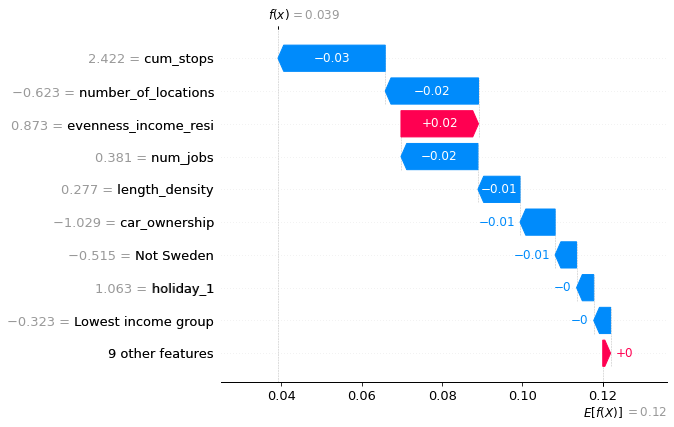

In [26]:
values = shap_values[0]
base_values = [explainer.expected_value[0]]*len(shap_values[0])

tmp = shap.Explanation(values = np.array(values, dtype=np.float32),
                       base_values = np.array(base_values, dtype=np.float32),
                       data=np.array(X_train[:5000]),
                       feature_names=predictors)

shap.plots.waterfall(tmp[0])

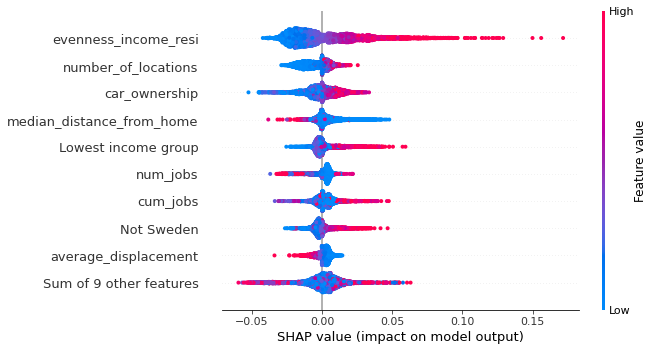

In [27]:
shap.plots.beeswarm(tmp)

In [28]:
df_preds_train = pd.DataFrame()
df_preds_train['evenness_income'] = y_train[:5000]
df_preds_train['prediction'] = pred_train[:5000]
df_preds_test = pd.DataFrame()
df_preds_test['evenness_income'] = y_test[:5000]
df_preds_test['prediction'] = pred[:5000]
df_preds_train.loc[:, 'label'] = 'train'
df_preds_test.loc[:, 'label'] = 'test'
df_preds = pd.concat([df_preds_train, df_preds_test])

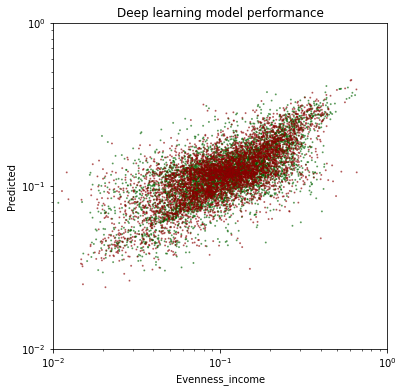

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x=df_preds['evenness_income'], y=df_preds['prediction'], s=1,
            c=df_preds['label'].map({'train':'darkgreen','test':'darkred'}), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-2), 1)
plt.ylim(10**(-2), 1)
plt.xlabel("Evenness_income")
plt.ylabel("Predicted")
plt.title('Deep learning model performance')
plt.show()

## 4. Train an EBM model

In [7]:
print('Training...')
seed = 1
ebm = ExplainableBoostingRegressor(interactions=5, random_state=seed, feature_names=predictors, outer_bags=4)
ebm.fit(X_train, y_train)  # Works on dataframes and numpy arrays

Training...


ExplainableBoostingRegressor(binning='quantile', early_stopping_rounds=50,
                             early_stopping_tolerance=0.0001,
                             feature_names=['weekday_0', 'weekday_1',
                                            'holiday_0', 'holiday_1',
                                            'number_of_locations',
                                            'number_of_visits',
                                            'average_displacement',
                                            'radius_of_gyration',
                                            'median_distance_from_home',
                                            'Not Sweden', 'Lowest income group',
                                            'car_ownership', 'cum_jobs',
                                            'cum_stops', 'evenness_income_resi',
                                            'num_jobs', 'num_stops',
                                            'length_density'],
                  

In [ ]:
# explain the GAM model with SHAP
background = shap.maskers.Independent(X_train, max_samples=1000)
explainer_ebm = shap.Explainer(ebm.predict, background)

In [14]:
shap_values_ebm = explainer_ebm(X_train[:10000])
shap_values_ebm.feature_names = predictors

Permutation explainer: 10001it [32:28,  5.10it/s]                           


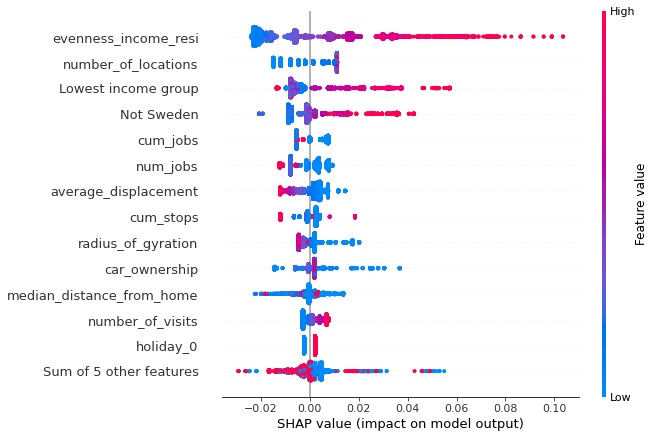

In [15]:
shap.plots.beeswarm(shap_values_ebm, max_display=14)